In [5]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, precision_score

from matplotlib import pyplot as plt

In [6]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [13]:
'''columns_keep = ['redispatch', 'level',
                'wind_gust_max_m/s',
                'wind_gust_max_m/s_lag1',
                'wind_gust_max_m/s_lag2',
                'wind_gust_max_m/s_lag3',
                'air_temperature_K_lag3',
                'wind_direction_degrees',
                'wind_direction_degrees_lag1',
                'wind_direction_degrees_lag2',
                'wind_direction_degrees_lag3',
                'wind_direction_gust_max_degrees',
                'wind_direction_gust_max_degrees_lag1',
                'wind_direction_gust_max_degrees_lag2',
                'wind_direction_gust_max_degrees_lag3',
                'humidity_percent_lag3']
df = df[columns_keep]''' #unnecessary when regularization

"columns_keep = ['redispatch', 'level',\n                'wind_gust_max_m/s',\n                'wind_gust_max_m/s_lag1',\n                'wind_gust_max_m/s_lag2',\n                'wind_gust_max_m/s_lag3',\n                'air_temperature_K_lag3',\n                'wind_direction_degrees',\n                'wind_direction_degrees_lag1',\n                'wind_direction_degrees_lag2',\n                'wind_direction_degrees_lag3',\n                'wind_direction_gust_max_degrees',\n                'wind_direction_gust_max_degrees_lag1',\n                'wind_direction_gust_max_degrees_lag2',\n                'wind_direction_gust_max_degrees_lag3',\n                'humidity_percent_lag3']\ndf = df[columns_keep]"

In [37]:
# Drop the rows to get appropriate test data
start_date = '2021-01-01'
end_date = '2023-11-14'
df = df.loc[start_date:end_date]

In [38]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

**Last redispatch status importance**

In [32]:
# importance of the last redispatch status for the training data
def last_redispatch(y_train, X_test):
    window_size = 2  #last 30 min
    last_redispatch_importance_train = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum() # also incorporate the level ???
        last_redispatch_importance_train.append(importance)
    # forward fill the last value of 'last_redispatch_importance' for the test data with exponentially decreasing values
    decay_factor = 0.9
    last_redispatch_importance_test = [last_redispatch_importance_train[-1] * (decay_factor ** i) for i in range(len(X_test))]

    return last_redispatch_importance_train, last_redispatch_importance_test

**XGBoost**\
tbd.

**K-fold cross-validation**\
tbd.

Average Recall: 0.6971813725490197
Average Accuracy: 0.5156249999999999
Average Confusion Matrix: [[14.   19.25]
 [ 4.   10.75]]
Average Recall (Train): 0.7308974625366152
Average Accuracy (Train): 0.7346725503639012
Average Confusion Matrix (Train): [[66311.66666667 23906.58333333]
 [ 2196.58333333  5966.16666667]]


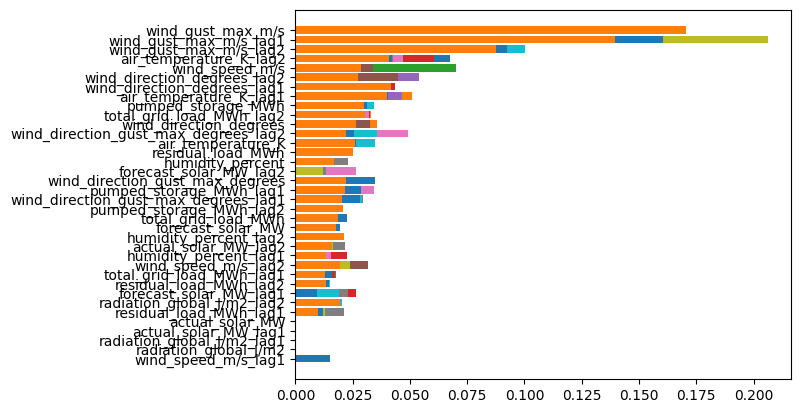

In [41]:
#xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=0, eval_metric='logloss', gamma = 1, # reg_alpha introduces L1 regularization
#                              n_estimators=100, max_depth=4, learning_rate=0.1, objective='binary:logistic', random_state = 13, scale_pos_weight=2)

# create model instance
xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=15, eval_metric='logloss', gamma = 1,
                              n_estimators=100, max_depth=2, learning_rate=0.1, objective='binary:logistic', random_state = 13, scale_pos_weight=1) #14
# reg_alpha = introduces L1 regularization (reduce overfitting)
# gamma = minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be (reduce overfitting)
# scale_pos_weights = assigns a higher weight to the minority class (positive class) to address class imbalance (think highen the recall)

# cross-validation
n_splits = 70
test_size = 48 #(12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

recall_scores = []
accuracy_scores = []
conf_matrices = []
recall_train_scores = []
accuracy_train_scores = []
conf_train_matrices = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # check if at least one instance of redispatch with status 1 is present in the test data
    if y_test.sum() == 0:
        continue
    '''
    # add importance of the last redispatch status
    last_redispatch_importance_train, last_redispatch_importance_test = last_redispatch(y_train, X_test)
    X_train['last_redispatch_importance'] = last_redispatch_importance_train
    X_test['last_redispatch_importance'] = last_redispatch_importance_test
    '''
    # preprocess data
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # fit model
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # make predictions
    y_pred = xgboost_class.predict(X_test_preprocessed)
    y_pred_train = xgboost_class.predict(X_train_scaled)

    #print(y_test.value_counts())
    #print("last redispatch importance: ", X_test['last_redispatch_importance'])

    # evaluate
    recall_scores.append(recall_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    recall_train_scores.append(recall_score(y_train, y_pred_train))
    accuracy_train_scores.append(accuracy_score(y_train, y_pred_train))
    conf_train_matrices.append(confusion_matrix(y_train, y_pred_train))

    sorted_idx = xgboost_class.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])


# print evaluation results
print("Average Recall:", sum(recall_scores) / len(recall_scores))
print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
print("Average Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))
print("Average Recall (Train):", sum(recall_train_scores) / len(recall_train_scores))
print("Average Accuracy (Train):", sum(accuracy_train_scores) / len(accuracy_train_scores))
print("Average Confusion Matrix (Train):", sum(conf_train_matrices) / len(conf_train_matrices))

**Grid Search CV**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Preprocess and oversample only the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocess the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

# Create XGBClassifier instance
xgboost_class = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic', random_state=13)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=xgboost_class, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train_preprocessed, y_train_preprocessed)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
'''
# Define the cross-validation strategy
n_splits = 16
test_size = 24  # 6h with 15 min intervals
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Define scoring metrics
scoring = {'recall': make_scorer(recall_score)}

# Perform cross-validation
recall_scores = cross_val_score(xgboost_class, X_train_preprocessed, y_train_preprocessed,
                                cv=tscv, scoring=scoring['recall'])

# Calculate the average recall score
average_recall = np.mean(recall_scores)
print("Average Recall Score with L1 regularization:", average_recall)
'''

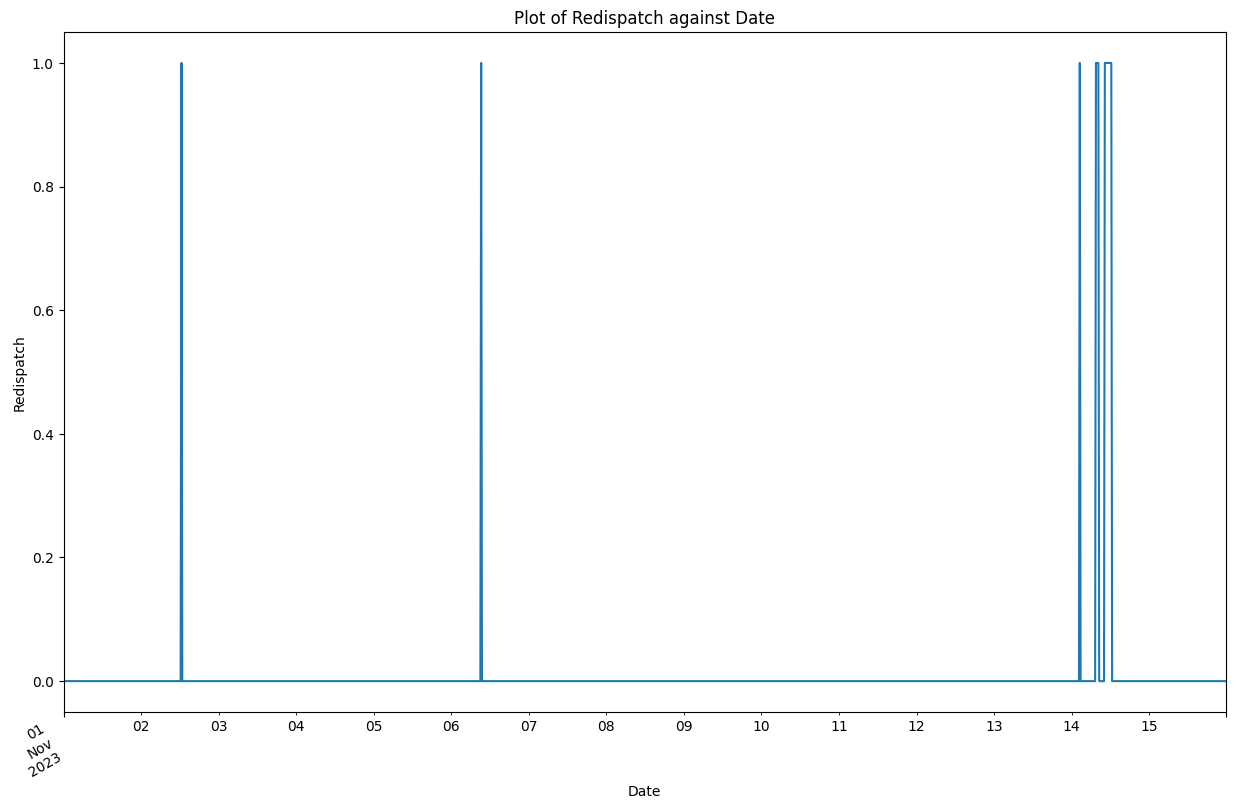

In [ ]:
# Plot the column against the datetime index
start_date = '2023-11-01'
end_date = '2023-11-15'

# Plot the data
ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()